# Anomaly Detection
Anomaly detection is used to detect outliers form a given dataset and can be seen from different points of view. For instance:
- Statistics: the idea would be to estimate the density of de distribution and then detect individuals atthe border of the distribution. It works well when you have prior knowledge on the data.
- Spectral: dimension reduction (Principal Component Analysis for instance) to look at the variance ofthe population, and anomalies/noise within a cohort. Good when looking at high dimensional data.
- Machine Learning: can look at the problem from a classification (outliers vs inliers), densityestimation or clustering point of view (K-means)

The following notebook will quickly display some of the most used functions in each approach on scaling noisy data, and while varying the main parameters. The dataset used is a classic 3 blobs datased with some noise added, which can be considered as a challenging dataset. **The following work isn't meant as an in depth analysis of which are the best anomaly detection algorithms**, but rather a display of the state of the art algorithms you'd want to consider for anomaly detection and how their main parameter influence theur behaviour. For the sake of visualization and comparison I compared all classifier on this dataset, though some don't make sense to be used in this peculiar context. It is only meant for visualization in understanding the algorithms logic in detecting outliers rather than comparing classifiers performance. 

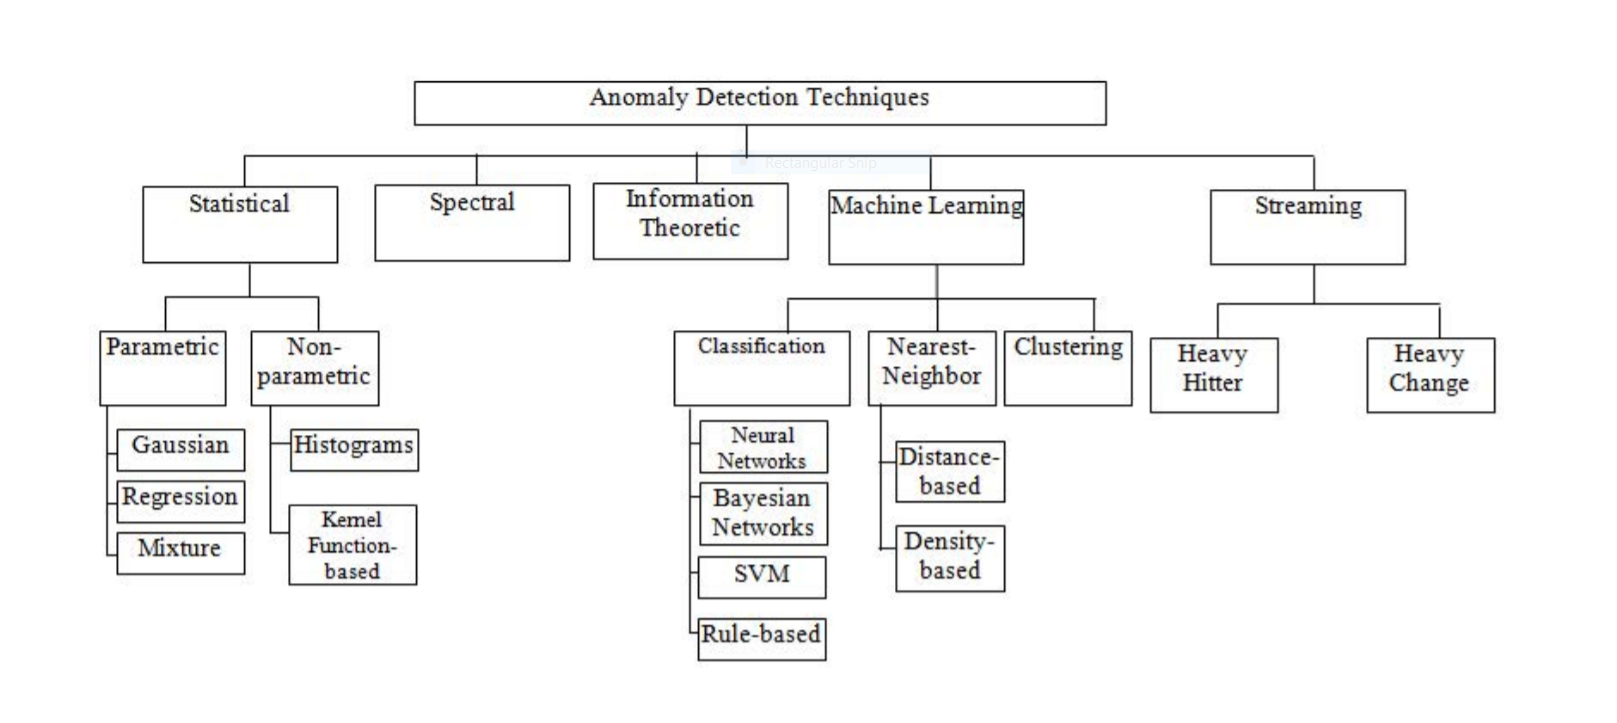

Source: https://pdfs.semanticscholar.org/f2a9/44c139038253e5a637bba6df2a1cc8985490.pdf

In [12]:
import time
import warnings

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('seaborn-poster')
matplotlib.rcParams['font.family'] = "serif"

from sklearn.datasets import make_blobs, make_moons
from sklearn.metrics import classification_report
# from sklearn.covariance import EllipticEnvelope (to be done)
# from sklearn.neighbors import LocalOutlierFactor (to be done)


from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn import metrics

from scipy.stats.mstats import mquantiles

import seaborn as sns
sns.set_context('paper')

rand_state = 42
warnings.filterwarnings('ignore')

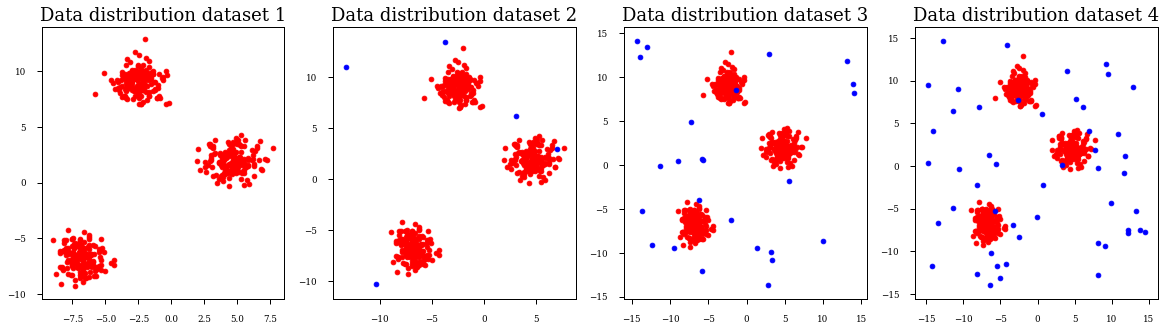

In [13]:
n_samples = 500
contamination = [0.1,1,5,10]
X_blob, y_blob = make_blobs(n_features=2, centers=3, n_samples=n_samples,
                  random_state=rand_state)
rng = np.random.RandomState(rand_state)
# X_noise = rng.uniform(low=-15, high=15,
#                        size=(20, 2))

# X_noise = np.concatenate([X_blob, rng.uniform(low=-15, high=15, size=(0, 2))], axis=0)
datasets = [np.concatenate([X_blob, rng.uniform(low=-15, high=15,
               size=(int(i*n_samples/100), 2))], axis=0) for i in contamination]

plt.figure(figsize = (5*len(datasets),5))
for i in range(len(datasets)):
    plt.subplot(1, len(datasets),i+1)
    plt.title('Data distribution dataset %d' %(i+1), fontsize = 18)
    plt.scatter(datasets[i][:n_samples,0], datasets[i][:n_samples,1], color = 'red')
    plt.scatter(datasets[i][n_samples:,0], datasets[i][n_samples:,1], color = 'blue')
plt.show()

In [14]:
# nb_noise = [0,50,100,150]
datasets = [np.concatenate([X_blob, rng.uniform(low=-15, high=15,
               size=(int(i*n_samples/100), 2))], axis=0) for i in contamination]

In [15]:
# Building grid
x_min, y_min = np.min([np.min(el, axis =0) for el in datasets], axis =0) - 1
x_max, y_max = np.max([np.max(el, axis =0) for el in datasets], axis =0) + 1
h = 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

grid = np.c_[xx.ravel(), yy.ravel()]

## Scoring
For the scoring we use the dataset 3

In [16]:
labels = np.concatenate((np.array([1]*n_samples),np.array([0]*int(n_samples*contamination[3]/100))), axis =0)
X_train, X_test, y_train, y_test = train_test_split(datasets[3], labels, random_state = rand_state)

## Plotting

In [24]:
def plot_function(model, estimators, quantiles = False):
    key = list(estimators.keys())[0] # we retrive the name of the main parameter we'll be modifying
    plt.figure(figsize = (5*len(datasets),5*len(estimators[key])))
    for i_dataset, data in enumerate(datasets): #looping on all datasets
        for j in range(len(estimators[key])):
            model.set_params(**{key:estimators[key][j]}) #setting parameters
            shuffle(data, replace = True, random_state = rand_state) #we concaneted the blobs and the noise so we want to shuffle our dataset
            model.fit(data)
            
            if type(model).__name__ == 'KMeans': #KMeans doesn't have score_sample
                score_model = model.predict(grid)
            else:
                score_model = model.score_samples(grid)
            score_model = score_model.reshape(xx.shape)
            
            plt.subplot(len(estimators[key]),len(datasets), i_dataset+1+j*len(datasets))
            
            if quantiles: #plotting quantiles if we want
                X_model = model.score_samples(data)

                alpha_set = 0.95
                tau_model = mquantiles(X_model, 1. - alpha_set)

                c_0 = plt.contour(xx, yy, score_model, levels=tau_model, colors='green', linewidths=3)
                plt.clabel(c_0, inline=1, fontsize=15, fmt={tau_model[0]: str(alpha_set)})
            
            if j==0:
                plt.title('%s \n %.2f noise samples' %(type(model).__name__, contamination[i_dataset]), fontsize=22)
                
            if type(model).__name__ == 'KMeans': #we plot centroids for KMeans
                plt.imshow(score_model, interpolation='nearest', extent=(xx.min(), xx.max(), yy.min(), yy.max()), cmap=plt.cm.Paired, aspect='auto', origin='lower')
                centroids = model.cluster_centers_
                plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=300, linewidths=3, color='b', zorder=10)
            else:
                plt.contourf(xx, yy, score_model, cmap=plt.cm.Blues_r)
            plt.scatter(data[:, 0], data[:, 1], s = 2, c= 'red')
            if i_dataset==0:
                if isinstance(estimators[key][j],str):
                    plt.ylabel('%s = %s' %(key, estimators[key][j]), fontsize=22)
                if isinstance(estimators[key][j], float):
                    plt.ylabel('%s = %.2f' %(key, estimators[key][j]), fontsize=22)
                if isinstance(estimators[key][j],int):
                    plt.ylabel('%s = %d' %(key, estimators[key][j]), fontsize=22)
            plt.xticks(())
            plt.yticks(())
            plt.axis('tight')
    plt.show()

# Kernel Density
Is a non-parametric way of estimating a **data's density**. Is is a fundamental data smoothing problem where inferences about the population are made based on a finite data sample. <br>
Main Kernel used: uniform, triangular, biweight, triweight, Epanechnikov, **normal**, and others.

- **PROS** :
    * good density estimation
    * good for sampling and generation
- **CONS** :
    * Slow
    * Not meant for anomaly detection
    * Will try to fit the data distribution even if there are outliers 

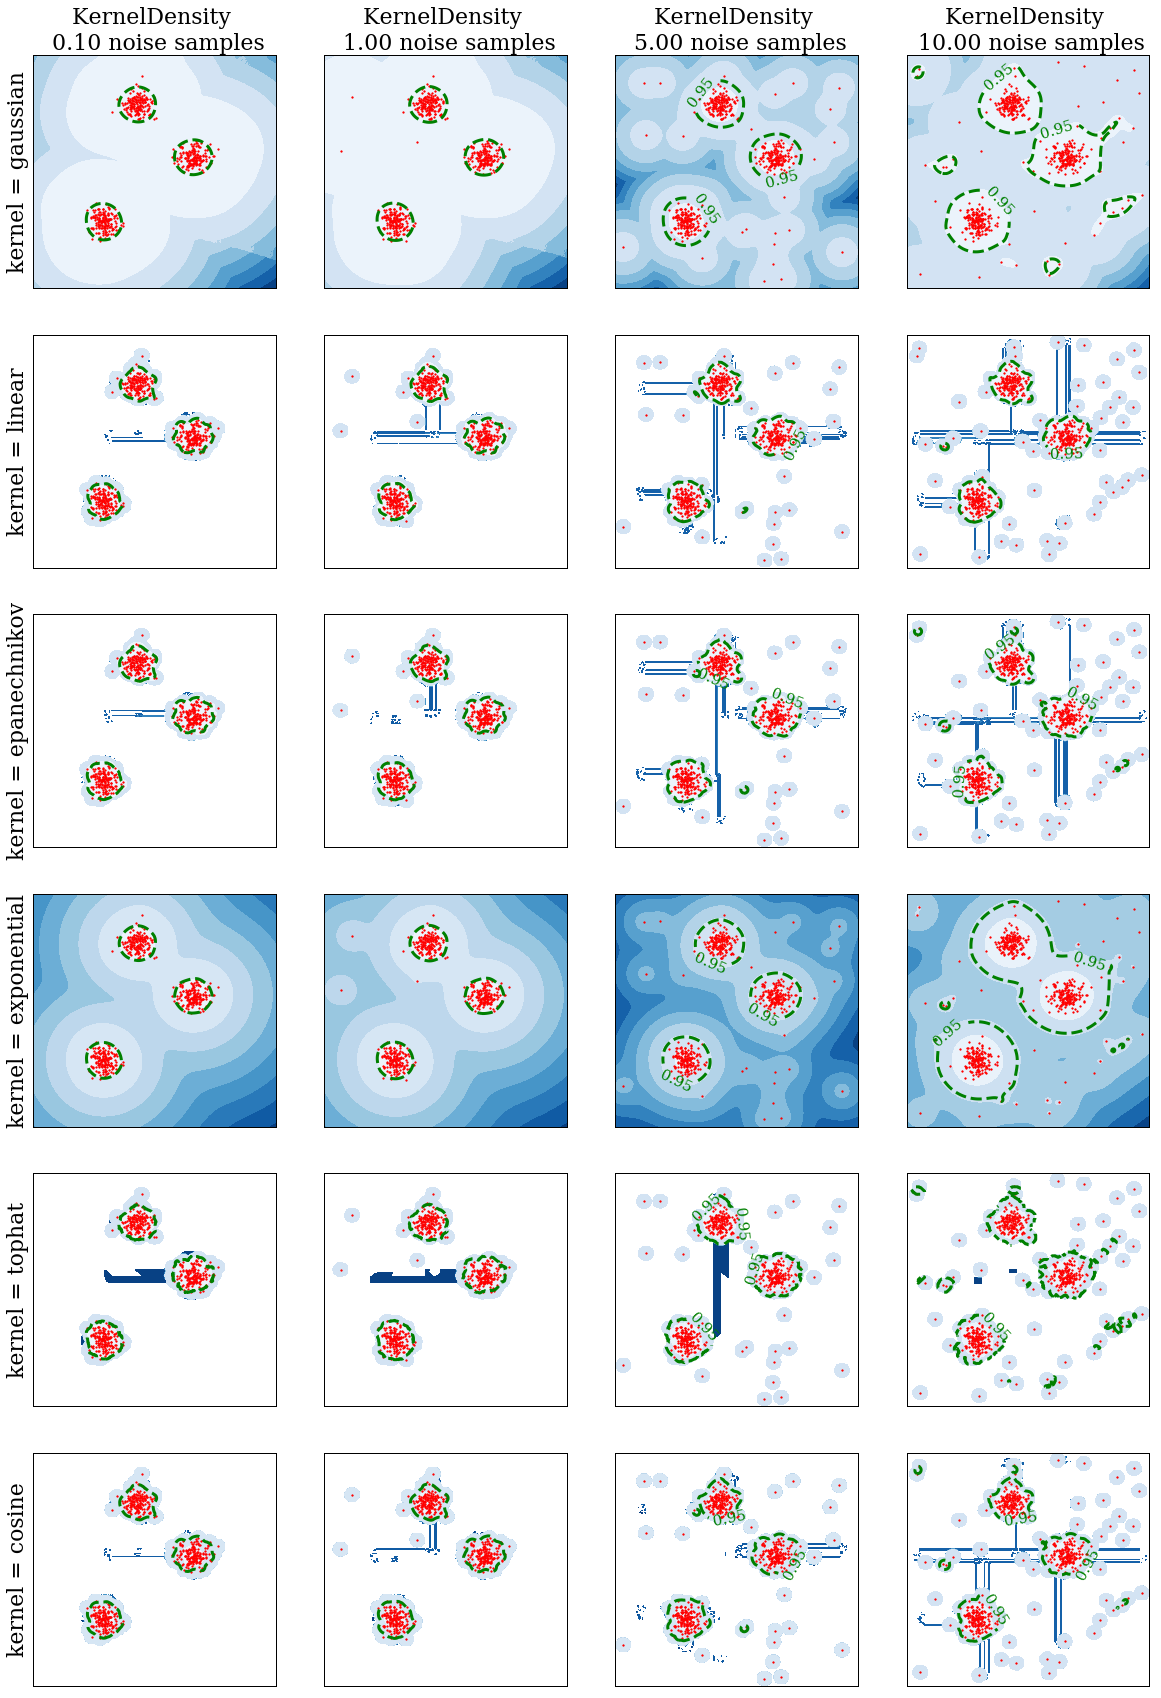

In [18]:
from sklearn.neighbors.kde import KernelDensity

### Parameters ###
model = KernelDensity(kernel='gaussian')
estimators = {'kernel':['gaussian', 'linear', 'epanechnikov', 'exponential', 'tophat', 'cosine']}

### Plotting ###
plot_function(model, estimators, quantiles = True)

# Gaussian Mixture
Density estimation by approximating it by a sum of gaussian distributions.

- **Pros**
    * Easy to implement
    * Can be applied in lots of applications
- **Cons**
    * Distance measures heuristic, why euclidean?
    * Warping paths heuristic
    * No guarantees of optimality
    * Can be computationnally costly

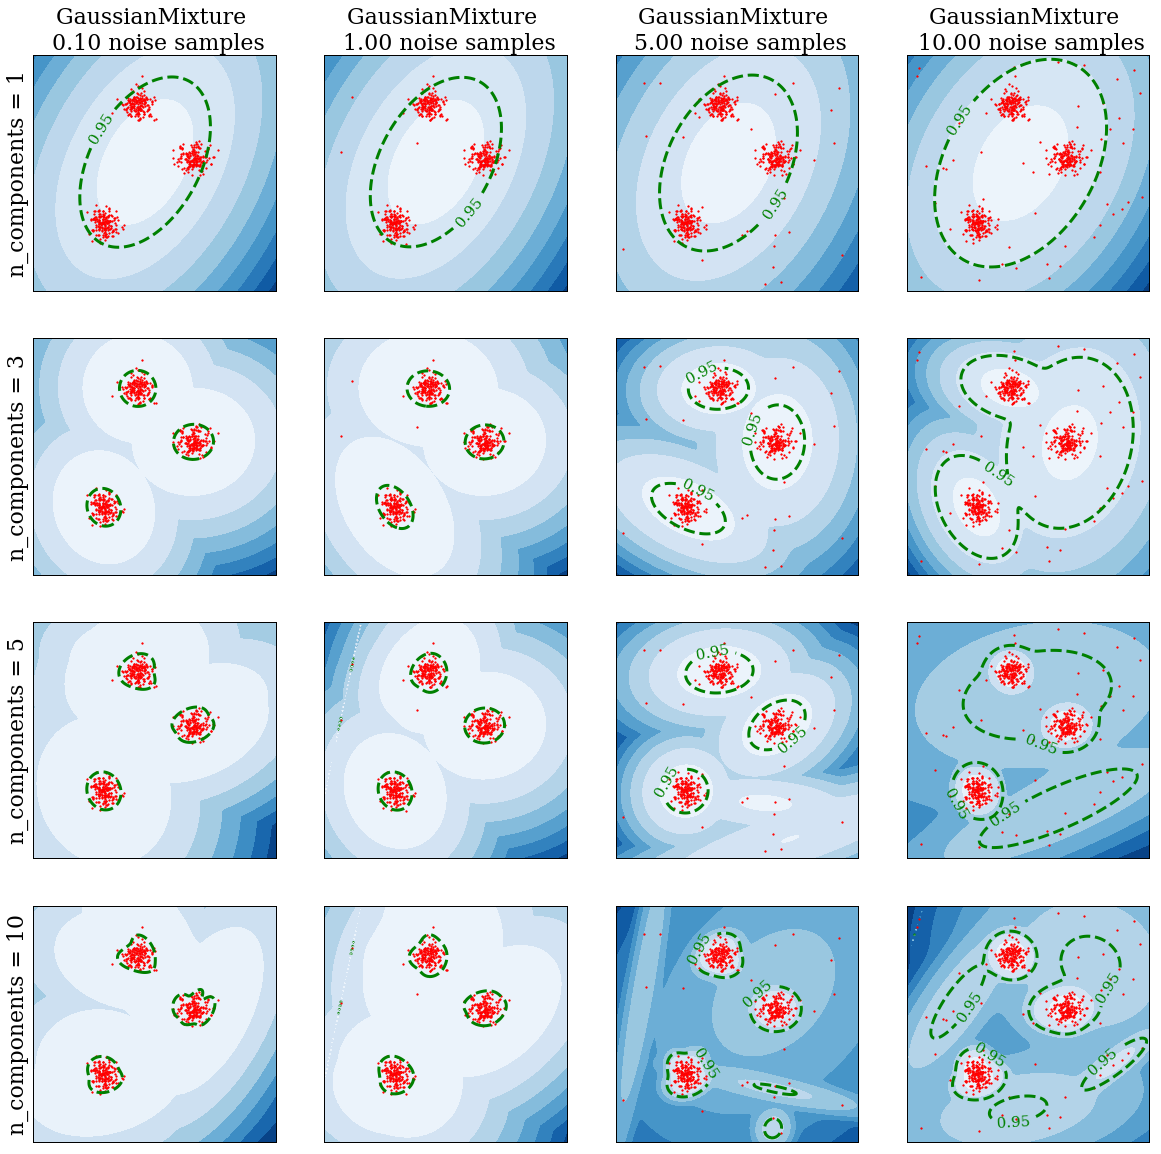

In [19]:
from sklearn.mixture import GaussianMixture

### Parameters ###
model = GaussianMixture()
estimators = {'n_components': [1,3,5,10]}

### Plotting ###
plot_function(model, estimators, quantiles = True)

# IsolationForest
Based tree anomaly detection algorithm. It builds trees, and the abnormality is based on the depth at which a sample ends up alon in a leaf.

- **Pros**:
    * Tree based, so quite quick to compute
    * Fairly effective for anomaly detection on unknown data
- **Cons**:
    * Very sharp
    * Not good on little clusters, like the blobs used here

Article:
https://cs.nju.edu.cn/zhouzh/zhouzh.files/publication/icdm08b.pdf

              precision    recall  f1-score   support

     anomaly       0.87      1.00      0.93        20
      normal       1.00      0.97      0.99       118

   micro avg       0.98      0.98      0.98       138
   macro avg       0.93      0.99      0.96       138
weighted avg       0.98      0.98      0.98       138



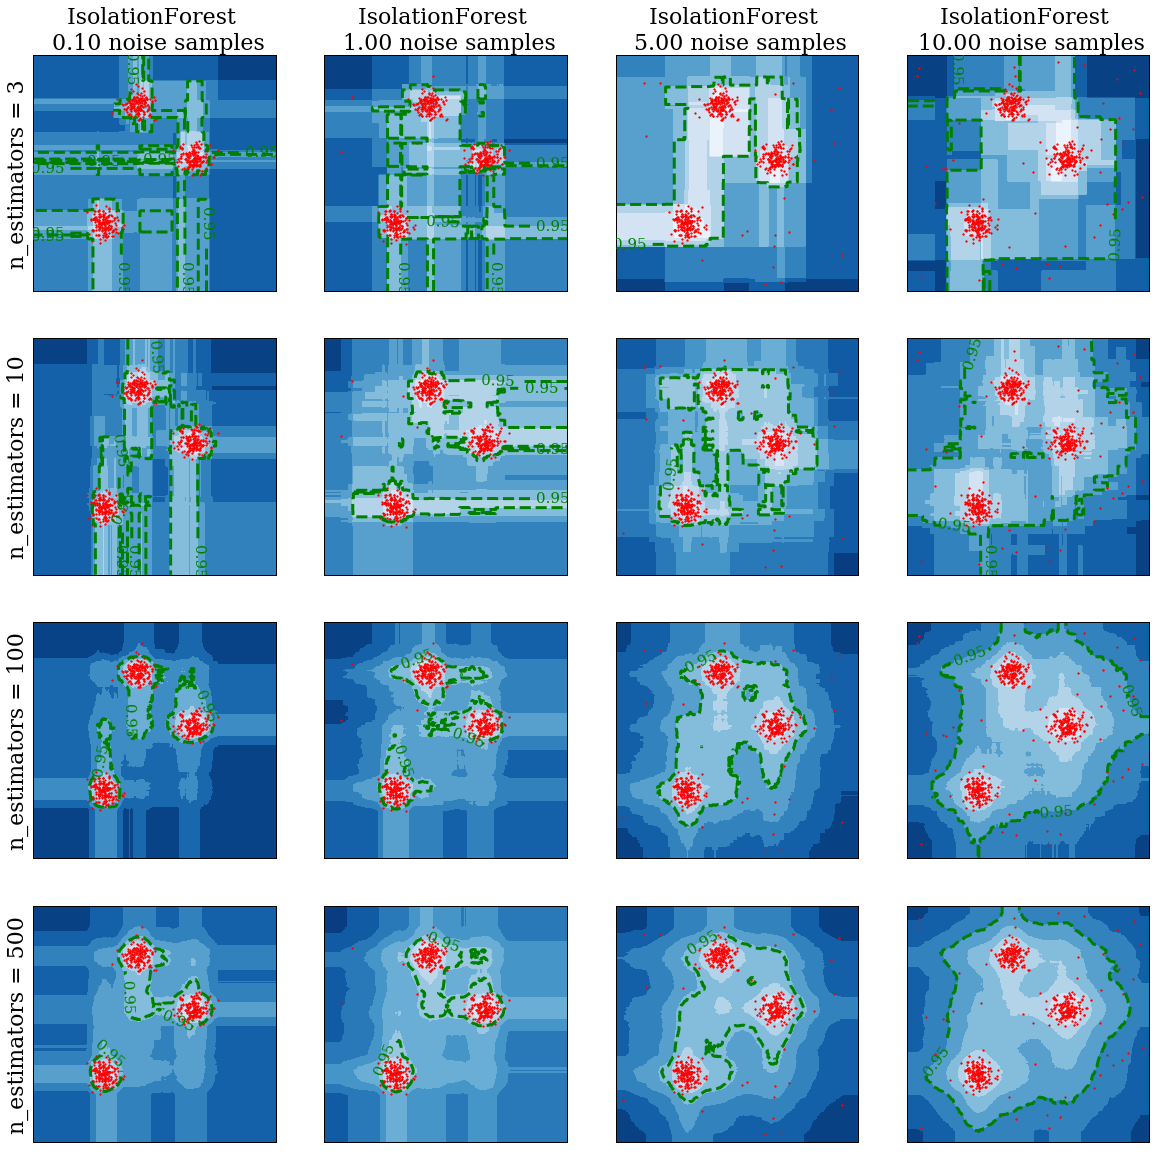

In [20]:
from sklearn.ensemble import IsolationForest

### Parameters ###
model = IsolationForest(n_estimators = 500)
estimators = {'n_estimators':[3,10,100,500]}

### Scoring ###
model.fit(X_train)
preds = model.predict(X_test)
preds = [x*(x>0) for x in preds]
print(classification_report(y_test,preds, target_names=['anomaly','normal']))

### Plotting ###
plot_function(model, estimators, quantiles = True)

# One Class SVM

- **Pros**:
    * Accuracy
    * Works well on small, clean datasets
    * Uses a subset of training points which can make it more efficient
    * Good when the data is not regularly distributed/unknown distribution
- **Cons**:
    * Not suited for large datasets
    * Long training time
    * Less effective on noiser datasets with overlapping classes

Sources:
https://www.kdnuggets.com/2016/07/support-vector-machines-simple-explanation.html


              precision    recall  f1-score   support

     anomaly       0.29      1.00      0.45        20
      normal       1.00      0.59      0.74       118

   micro avg       0.65      0.65      0.65       138
   macro avg       0.65      0.80      0.60       138
weighted avg       0.90      0.65      0.70       138



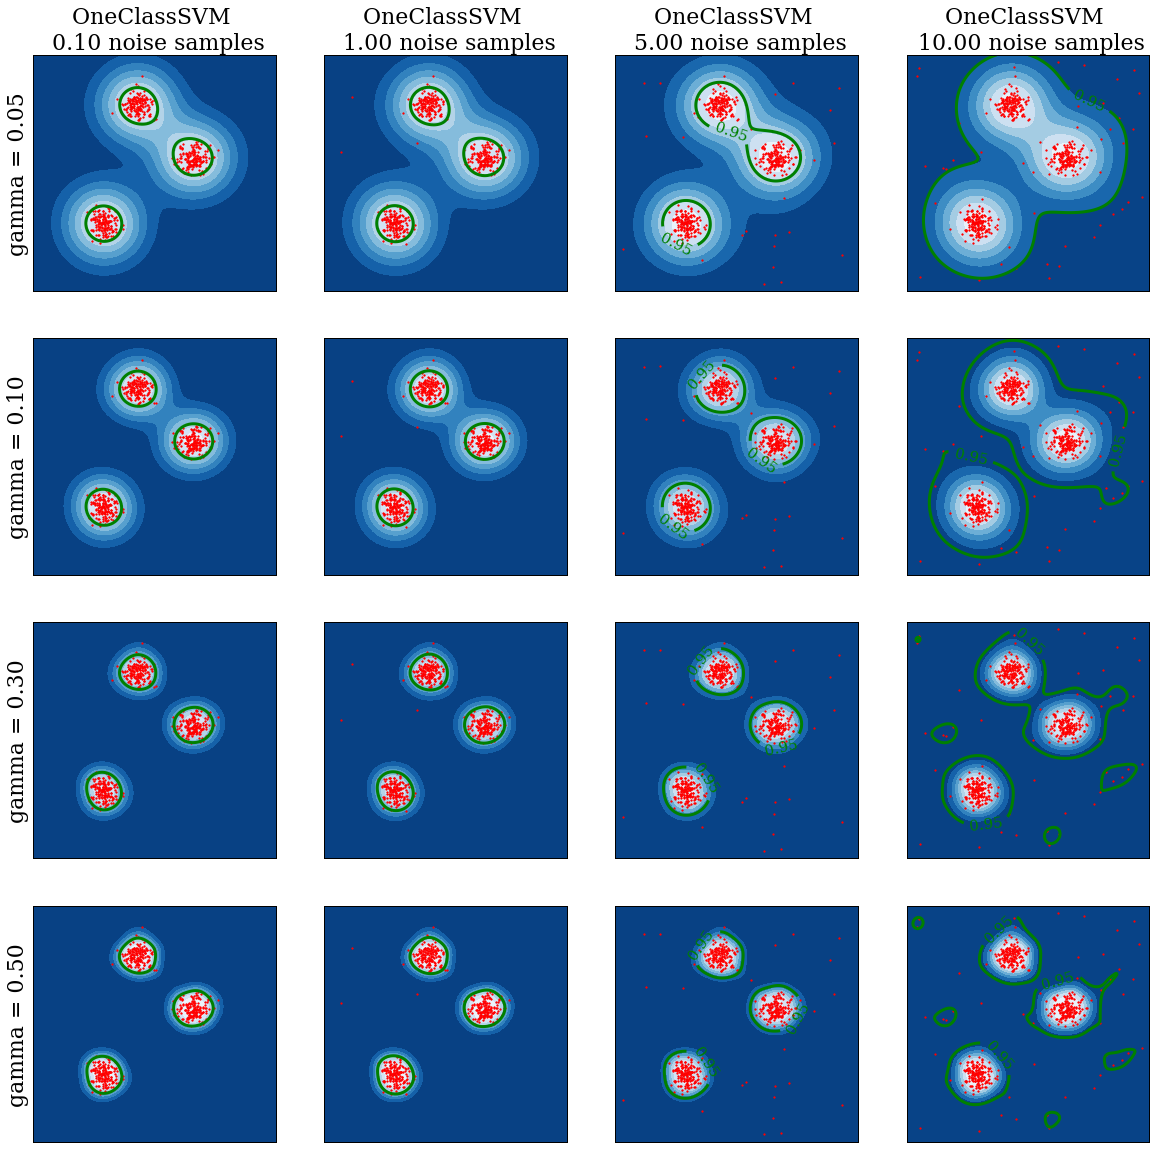

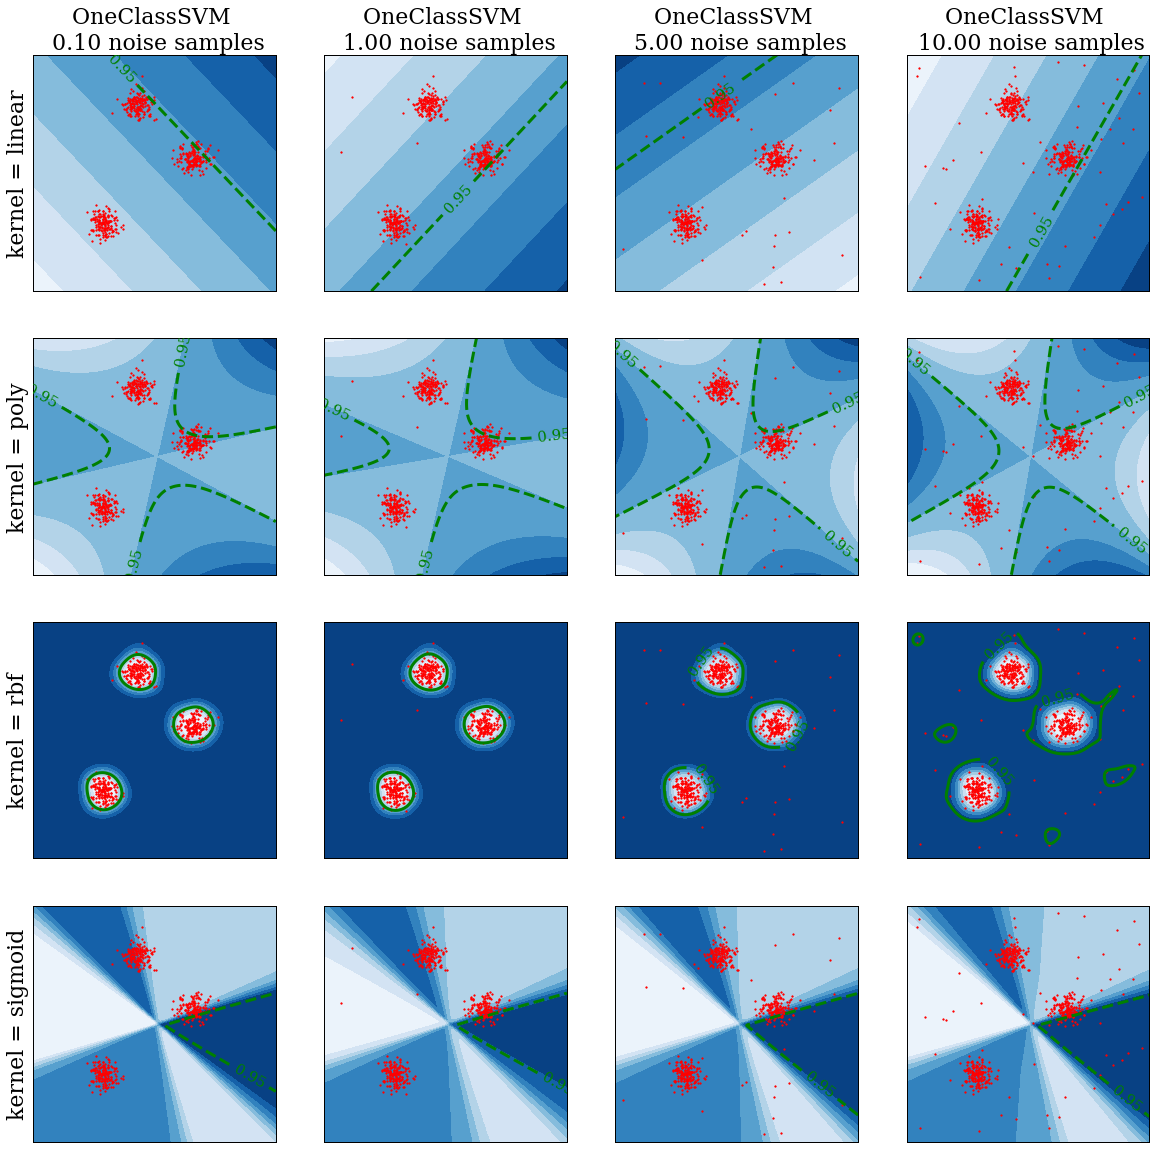

In [21]:
from sklearn.svm import OneClassSVM

### Parameters ###
model = OneClassSVM(kernel = 'rbf', gamma = 0.5)
estimators ={'gamma':[0.05, 0.1,0.3, 0.5]}

###Scoring###
model.fit(X_train)
preds = model.predict(X_test)
preds = [x*(x>0) for x in preds]
print(classification_report(y_test,preds, target_names=['anomaly','normal']))

### Plotting gamma ###
plot_function(model, estimators, quantiles = True)

estimators = {'kernel':['linear', 'poly', 'rbf', 'sigmoid']} #obviously here, most won't have any sense since we're dealing with blobs

### Plotting Kernel ###
plot_function(model, estimators, quantiles = True)

# Principal Component Analysis (PCA)
It is used to extract the main features of a cohort by finding vectors which support the longest projection of the distribution. The first degrees of PCA describe the variance of the sample while further degrees tend to describe noises or anomalies within the dataset. Is is mainly used to reduce dimensionality in complex problems. Obviously here it isn't optimal to use it on 2D blobs, but I did it for the sake of visualization and comparison.

- **Pros**:
    * Good description of the distribution
    * Quite efficient when looking at clean data (not a lot of noise)
    * Can help reduce dimension in order to get a clearer projection of the distribution
- **Cons**:
    * You don't have much details on wether the direction you're looking at is noise or anomalies
    * Not a lot of interpretability

              precision    recall  f1-score   support

     anomaly       1.00      0.55      0.71        20
      normal       0.93      1.00      0.96       118

   micro avg       0.93      0.93      0.93       138
   macro avg       0.96      0.78      0.84       138
weighted avg       0.94      0.93      0.93       138



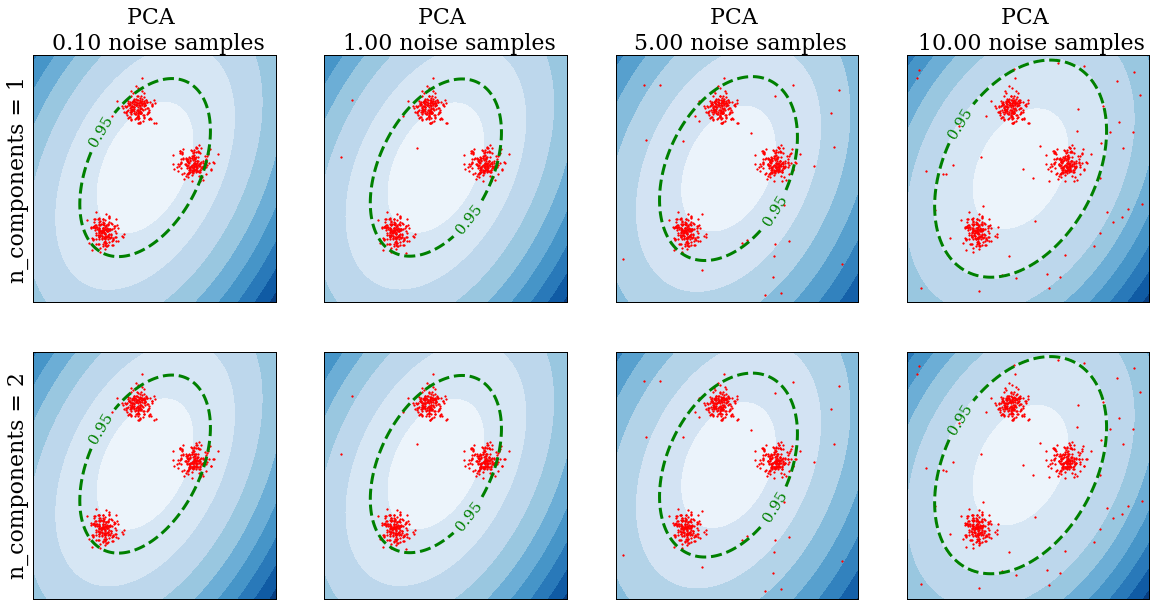

In [22]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

model = PCA()
estimators = {'n_components' : [1,2]}

model.fit(X_train)
preds = normalize(model.score_samples(X_test).reshape(1,-1))
preds = [1*(x>=-0.10) for x in preds][0]
print(classification_report(y_test,preds, target_names=['anomaly','normal']))

### Plotting gamma ###
plot_function(model, estimators, quantiles = True)

# K-Means
Clustering algorithm which, given a number of centers, will try to divide the data within the centers. The result is dependent of the initial configuration, so multiple initialzation are recommended. It is not 

- **Pros**:
    * Good naive approach to unsupervised learning
    * Good to detect clusters before running stastical approach
    * Quick to compute
- **Cons**:
    * Not especially meant for anomaly detection, but rather for cluster detection
    * Prior knowledge of the data strongly recommended if used purely for anomaly detection
    * Hard to tune the number of centroids and initialization

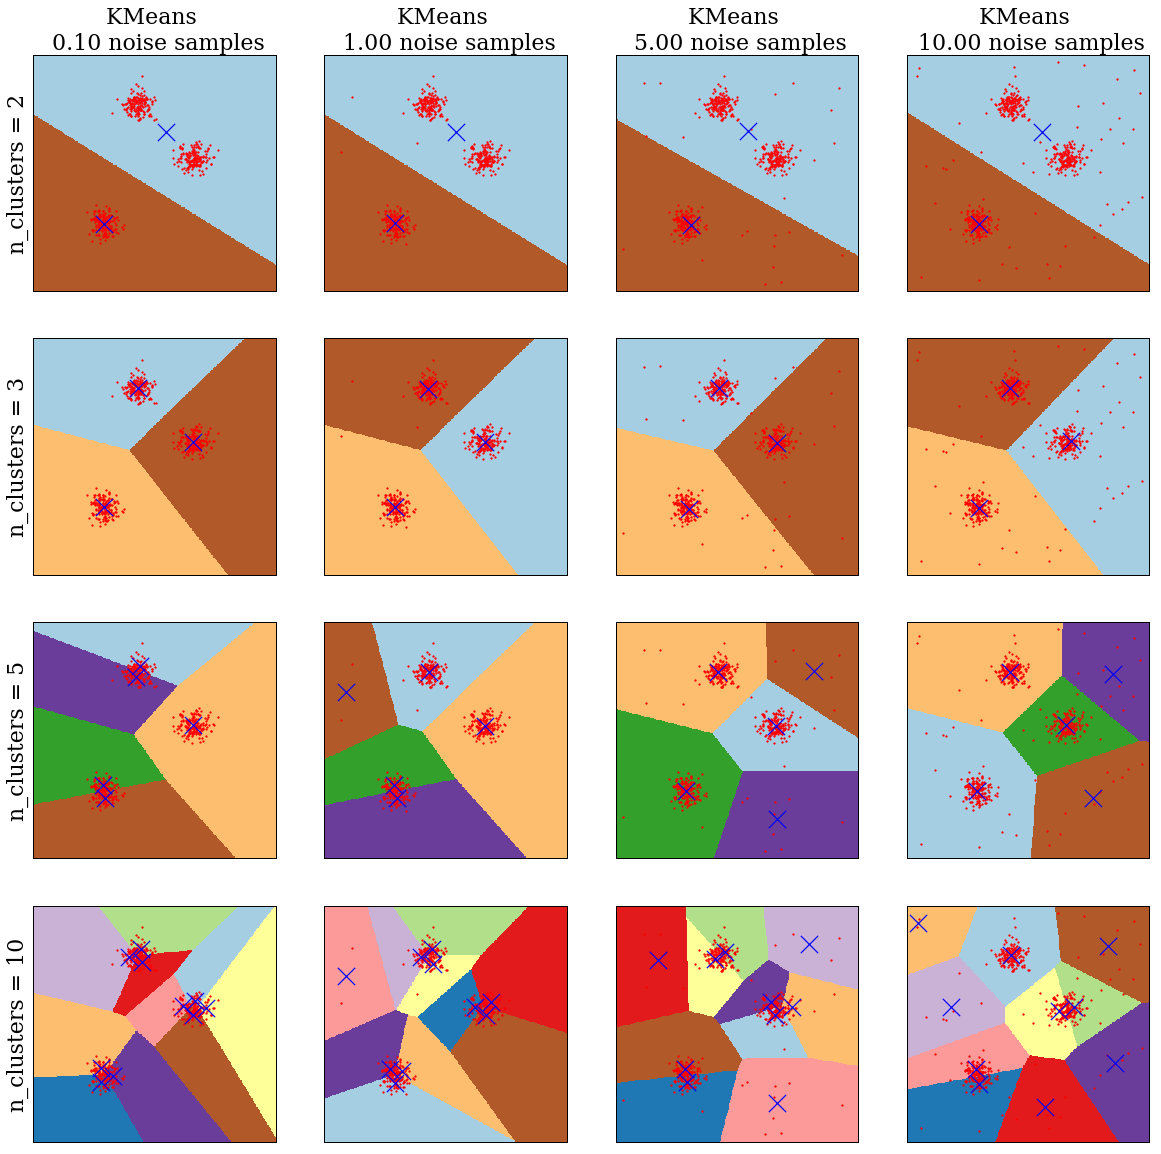

In [23]:
from sklearn.cluster import KMeans

### Parameters ###
model = KMeans()
estimators = {'n_clusters': [2,3,5,10]}

### Plotting ###
plot_function(model, estimators)

# Neural Networks
Vast topic, this article will be my first step to build this section:<br>
https://arxiv.org/pdf/1802.06360.pdf <br>
Then<br>
https://arxiv.org/abs/1901.03407<br>
GAN maybe?<br>
https://arxiv.org/pdf/1904.01209v1.pdf<br>
Didn't read those yet so I don't know what to expect<br>

# Conclusion
This is a very short presentation of anomaly detection algorithms. Here the data was a bit messy, which can explain the lower performances from OneClassSVM, as well as not tuning the gamma parameter which is important. All other algorithms would be very specific to a given context, but can prove to be useful. Anyway at least IsolationForest and OneClassSVM should be tried while tackling an anomaly detection problem.<br>
I recommend the beginning of this article for a clear explanation of the state of the art in anomaly detection (the beginning picture comes from this article): https://pdfs.semanticscholar.org/f2a9/44c139038253e5a637bba6df2a1cc8985490.pdf.

for plot style: https://medium.com/@andykashyap/top-5-tricks-to-make-plots-look-better-9f6e687c1e08

### Inspiration###
https://www.kaggle.com/simotn/anomaly-detection-dr-rebai-ahmed <br>
https://scikit-learn.org/stable/auto_examples/ensemble/plot_isolation_forest.html#sphx-glr-auto-examples-ensemble-plot-isolation-forest-py<br>
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4836738/<br>
    --> good panel of all anomaly detection algorithm, but a bit old (2016) so no information on iforest <br>
for plot style: https://medium.com/@andykashyap/top-5-tricks-to-make-plots-look-better-9f6e687c1e08 <br>
    
Further improvements:
- Local Outlier Factor
- Robust Covariance